In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import GlobalAveragePooling1D
import yfinance as yf

In [2]:
data = yf.download('BTC-USD', start="2014-09-17", end="2024-04-29")

[*********************100%%**********************]  1 of 1 completed


In [3]:
print(data.head(5))
print("------------------------------------------------------------------")
print(data.shape)
print(type(data))

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  
------------------------------------------------------------------
(3512, 6)
<class 'pandas.core.frame.DataFrame'>


<Axes: title={'center': 'Bitcoin stock plot'}, xlabel='Date'>

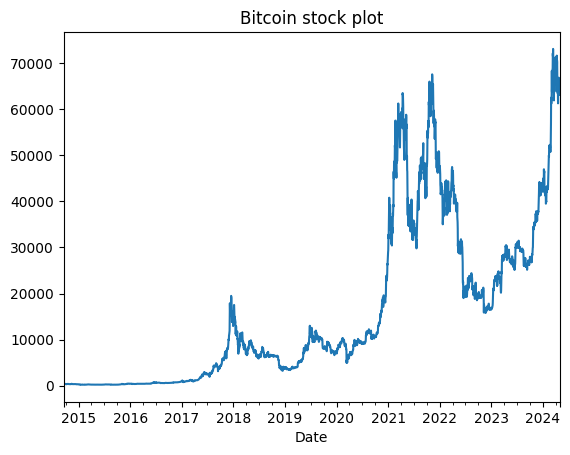

In [4]:
data['Close'].plot(title='Bitcoin stock plot')

In [5]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [6]:
train_size = int(len(data)*0.90)
test_size = len(data)-train_size
print(train_size)
print(test_size)

3160
352


In [7]:
train_data,test_data=data_scaled[0:train_size,:],data_scaled[train_size:len(data_scaled),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3160, 1)
test_data:  (352, 1)


In [25]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
time_step = 15
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (3145, 15)
y_train:  (3145,)
X_test:  (337, 15)
y_test (337,)


In [27]:
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1) #sample, time step, features
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)
print("X_train: ", x_train.shape)
print("X_test: ", x_test.shape)

X_train:  (3145, 15, 1)
X_test:  (337, 15, 1)


In [28]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   use_bias=True,
                   dropout=0.0,
                   return_sequences=True,
                   name="LSTM-1",
                   input_shape=(x_train.shape[1], 1)))  # Ensure x_train is passed as an argument
    model.add(LSTM(64,
                   activation='tanh',
                   recurrent_activation='sigmoid',
                   use_bias=True,
                   dropout=0.2,
                   return_sequences=True,
                   name="LSTM-2"))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64))
    model.add(Dense(32))
    return model

In [29]:
model = create_lstm_model()
model.summary()
model.compile(optimizer='adam',
    loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM-1 (LSTM)               (None, 15, 128)           66560     
                                                                 
 LSTM-2 (LSTM)               (None, 15, 64)            49408     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
Total params: 122,208
Trainable params: 122,208
Non-trainable params: 0
________________________________________________

In [30]:
checkpoint_filepath = 'model_{epoch}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_loss',
    mode='min',
    save_best_only=True
)

model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 10,
    verbose = 1, #shows message whnen callback takes an action
    mode = 'min',
    restore_best_weights = True
)

history = model.fit(x_train,
    y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks = [model_checkpoint_callback])

Epoch 1/100
99/99 [==============================] - 10s 47ms/step - loss: 0.0117 - val_loss: 0.0037
Epoch 2/100
99/99 [==============================] - 4s 37ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 3/100
99/99 [==============================] - 5s 50ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 4/100
99/99 [==============================] - 4s 36ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 5/100
99/99 [==============================] - 4s 37ms/step - loss: 0.0013 - val_loss: 0.0072
Epoch 6/100
99/99 [==============================] - 4s 45ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/100
99/99 [==============================] - 4s 39ms/step - loss: 9.6201e-04 - val_loss: 0.0046
Epoch 8/100
99/99 [==============================] - 4s 37ms/step - loss: 9.9988e-04 - val_loss: 0.0016
Epoch 9/100
99/99 [==============================] - 4s 41ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 10/100
99/99 [==============================] - 5s 45ms/step - loss: 8.9086e-04 - val

In [31]:
training_prediction = model.predict(x_train)
test_prediction = model.predict(x_test)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
training_prediction = scaler.inverse_transform(training_prediction)
test_prediction = scaler.inverse_transform(test_prediction)

11/11 [==============================] - 0s 14ms/step


In [32]:
train_score = np.sqrt(mean_squared_error(y_train, training_prediction[:,0]))
print(train_score)

1024.2565610519487


In [33]:
test_score = np.sqrt(mean_squared_error(y_test, test_prediction[:, 0]))
print(test_score)

1484.6191885542555


In [34]:
#r-2 score
train_r2 = r2_score(training_prediction[:,0], y_train)
print(train_r2)
test_r2 = r2_score(test_prediction[:,0], y_test)
print(test_r2)

0.9961686263867062
0.9892944459502943


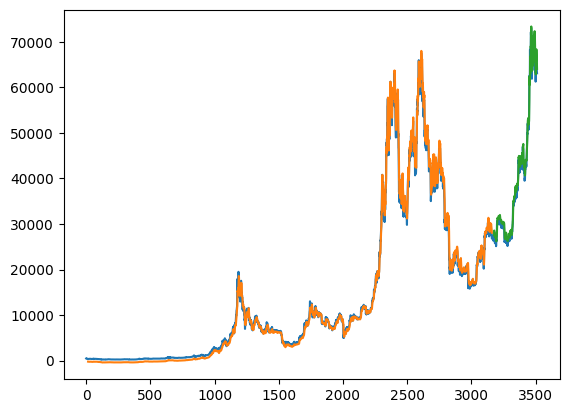

In [37]:
### Plotting
# shift train predictions for plotting
look_back=15
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(training_prediction)+look_back, 0] = training_prediction[:,0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(training_prediction)+(look_back*2):len(data_scaled), 0] = test_prediction[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [49]:
print(x_test[-2:])

[[[0.91924284]
  [0.87295828]
  [0.89925611]
  [0.86753671]
  [0.87282647]
  [0.83805302]
  [0.86872376]
  [0.87326138]
  [0.88904719]
  [0.88811726]
  [0.91432979]
  [0.90842617]
  [0.87920508]
  [0.88201432]
  [0.8720509 ]]

 [[0.87295828]
  [0.89925611]
  [0.86753671]
  [0.87282647]
  [0.83805302]
  [0.86872376]
  [0.87326138]
  [0.88904719]
  [0.88811726]
  [0.91432979]
  [0.90842617]
  [0.87920508]
  [0.88201432]
  [0.8720509 ]
  [0.86743973]]]


In [51]:
print(y_test[-2:])

[[63419.140625  ]
 [63113.23046875]]


In [46]:
print(test_prediction[-1])

[64074.535 64092.094 64020.15  64181.863 63630.426 64002.543 64141.777
 63944.01  63717.973 64096.613 63985.117 63894.484 64061.36  64384.254
 63976.06  63907.523 64004.645 64039.87  64186.39  64039.74  64158.805
 63895.61  64073.254 64067.145 64173.74  64257.    63854.254 63961.555
 63911.938 64344.375 64163.285 64390.176]


In [50]:
model.predict(x_test[-2:])

1/1 [==============================] - 0s 31ms/step


array([[0.8929243 , 0.89050674, 0.8930308 , 0.8921115 , 0.8844446 ,
        0.8900069 , 0.89168775, 0.88771564, 0.8867577 , 0.8905427 ,
        0.8870375 , 0.88957584, 0.8913437 , 0.89444953, 0.88781285,
        0.888495  , 0.89063746, 0.8943601 , 0.8918193 , 0.88910306,
        0.89335215, 0.8867509 , 0.8895784 , 0.89305437, 0.89194953,
        0.89567155, 0.8893138 , 0.89047784, 0.88857424, 0.8930353 ,
        0.89373034, 0.89610183],
       [0.87642944, 0.8766701 , 0.87568355, 0.87790155, 0.87033784,
        0.875442  , 0.8773519 , 0.8746391 , 0.8715387 , 0.8767322 ,
        0.8752028 , 0.87395984, 0.8762487 , 0.88067764, 0.87507856,
        0.8741388 , 0.8754706 , 0.8759538 , 0.87796366, 0.8759519 ,
        0.8775852 , 0.87397546, 0.87641186, 0.876328  , 0.8777899 ,
        0.8789321 , 0.87340784, 0.8748796 , 0.87419903, 0.8801304 ,
        0.8776466 , 0.88075876]], dtype=float32)

In [55]:
scaler.inverse_transform(model.predict(x_test[-2:]))[:,0]

1/1 [==============================] - 0s 43ms/step


array([65277.105, 64074.54 ], dtype=float32)

In [56]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,66408.718750,67075.367188,63589.871094,64276.898438,64276.898438,30276655120
2024-04-25,64275.019531,65275.207031,62783.632812,64481.707031,64481.707031,32155786816
2024-04-26,64485.371094,64789.656250,63322.398438,63755.320312,63755.320312,24139372950
2024-04-27,63750.988281,63898.363281,62424.718750,63419.140625,63419.140625,19530783039
2024-04-28,63423.515625,64321.484375,62793.597656,63113.230469,63113.230469,17334827993


In [97]:
input = np.array(x_test[-1:])
pred = model.predict(input)
pred_unscaled = scaler.inverse_transform(pred)[:,0]

for i in range(0,8):
    input = np.append(np.delete(input, 0, axis=1), [[pred[:,0]]], axis=1)
    pred = model.predict(input)
    pred_unscaled = scaler.inverse_transform(pred)[:,0]
    if i > 0:
        print(pred_unscaled)


1/1 [==============================] - 0s 47ms/step
[66380.875]
1/1 [==============================] - 0s 45ms/step
[67559.11]
1/1 [==============================] - 0s 43ms/step
[67965.945]
1/1 [==============================] - 0s 37ms/step
[68670.12]
1/1 [==============================] - 0s 45ms/step
[68978.945]
1/1 [==============================] - 0s 38ms/step
[69396.42]
1/1 [==============================] - 0s 44ms/step
[69824.67]
